In [1]:
### Get Quality Metrics

# Import libraries
import pandas as pd
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, Trace
client = Client("IRIS")

### Module structure
- provide start and endtime, return percentage good hours between them
- provide start and end time, return good data between them
- provide start and endtime, return good/bad time series
- provide start and endtime, return data with good/bad time series

In [2]:
# want to read a specific quality url
netID='XE'
staID='CC01'
locID=''
chaID='BHZ'

url =f'https://obsic-metrics.whoi.edu/static/images/quality/{netID}/{staID}_{chaID}.txt'

# read in the data
data = pd.read_csv(url, delimiter=',', header=2, names=['DateTime', 'Quality'])

# now specify start and end window
starttime = '2018-07-26T00:00:00'
endtime = '2018-07-26T23:59:54'

# concatenate the binary good/not good hourly string
quality_string = ''.join(data['Quality'].astype(str).values)

# for a starttime, calculate the index into the quality string
startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)

# substring from startindex to endindex and put into ndarray
qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])

# this gives us a numpy array of ones and zeros from startindex to endindex

# mode 1:  return percentage good hours

pctgood = qualarr.sum()/len(qualarr)*100
print(f'Percentage good hours from {starttime} to {endtime} is {pctgood:.1f}%')

# mode 2:  return times and qualities of good and bad data

#put them into an obspy Trace object
stats = {'network': netID, 'station': staID, 'location': locID, 'channel': f'{chaID[0]}Q{chaID[2]}',
         'npts': len(qualarr), 'sampling_rate': 1/3600,
         'starttime': UTCDateTime(starttime)}
tr = Trace(data=qualarr, header=stats)

# mode 3:  return the actual data for the time window

st = client.get_waveforms(netID, staID, locID, chaID, UTCDateTime(starttime), UTCDateTime(endtime))
st += tr

# mode 4 (non-obspy)




Percentage good hours from 2018-07-26T00:00:00 to 2018-07-26T23:59:54 is 100.0%


In [3]:
# put Quality into one long string
quality_string = ''.join(data['Quality'].astype(str).values)

startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)

qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])

stats = {'network': netID, 'station': staID, 'location': locID, 'channel': 'BQZ',
         'npts': len(qualarr), 'sampling_rate': 1/3600,
         'starttime': UTCDateTime(starttime)}
tr = Trace(data=qualarr, header=stats)
st += tr

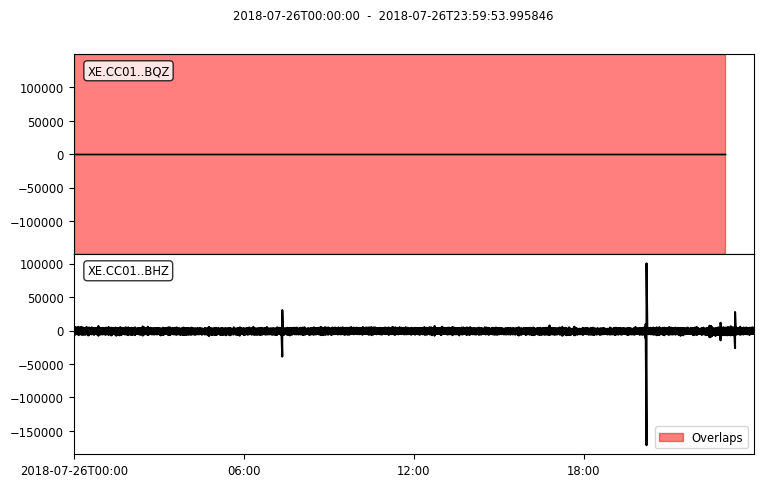

In [4]:
st.plot();

In [5]:
# to access the quality file quickly

# put Quality into one long string
quality_string = ''.join(data['Quality'].astype(str).values)

startindex = int((UTCDateTime(starttime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)
endindex = int((UTCDateTime(endtime)-UTCDateTime(data['DateTime'].iloc[0]))/3600)

qualarr=np.array([int(char) for char in quality_string[startindex:endindex+1]])